### Preprocess image data

In [1]:
from data_utils.crop import DatasetGridCropper, ImageGridCropper
from data_utils.dataset import LaddDataset
import tqdm
import json

config = json.load(open('config.json', 'r'))
LADD_PATH = config['ladd_voc_path']
LADD_CROP_BASE_PATH = config['ladd_crop_base_path']

if not os.path.isdir(LADD_CROP_BASE_PATH):
    os.mkdir(LADD_CROP_BASE_PATH)

cropper = DatasetGridCropper(
        source_dataset=LaddDataset(path=LADD_PATH),
        target_dataset=LaddDataset(path=LADD_CROP_BASE_PATH),
        image_cropper=ImageGridCropper(
            window_w=224,
            window_h=224,
            overlap_w=112,
            overlap_h=112,
            min_cropped_bbox_square=0.8
        ),
        iter_callback=tqdm.tqdm
    )
cropper.generate_dataset('pedestrian')

cropper = DatasetGridCropper(
        source_dataset=LaddDataset(path=LADD_PATH),
        target_dataset=LaddDataset(path=LADD_CROP_BASE_PATH),
        image_cropper=ImageGridCropper(
            window_w=224,
            window_h=224,
            overlap_w=1,
            overlap_h=1,
            min_cropped_bbox_square=0.8
        ),
        iter_callback=tqdm.tqdm
    )
cropper.generate_dataset('background')

0%|          | 0/411 [00:00<?, ?it/s]Reading source dataset...
Generate fragments...
100%|██████████| 411/411 [00:11<00:00, 34.31it/s]
Filter pedestrian fragments...
  0%|          | 0/411 [00:00<?, ?it/s]Reading source dataset...
Generate fragments...
100%|██████████| 411/411 [00:12<00:00, 33.83it/s]
Filter background fragments...
100%|██████████| 70772/70772 [37:45<00:00, 31.24it/s]


### Lets watch the `raw` data!

Pedestrian size: 3397


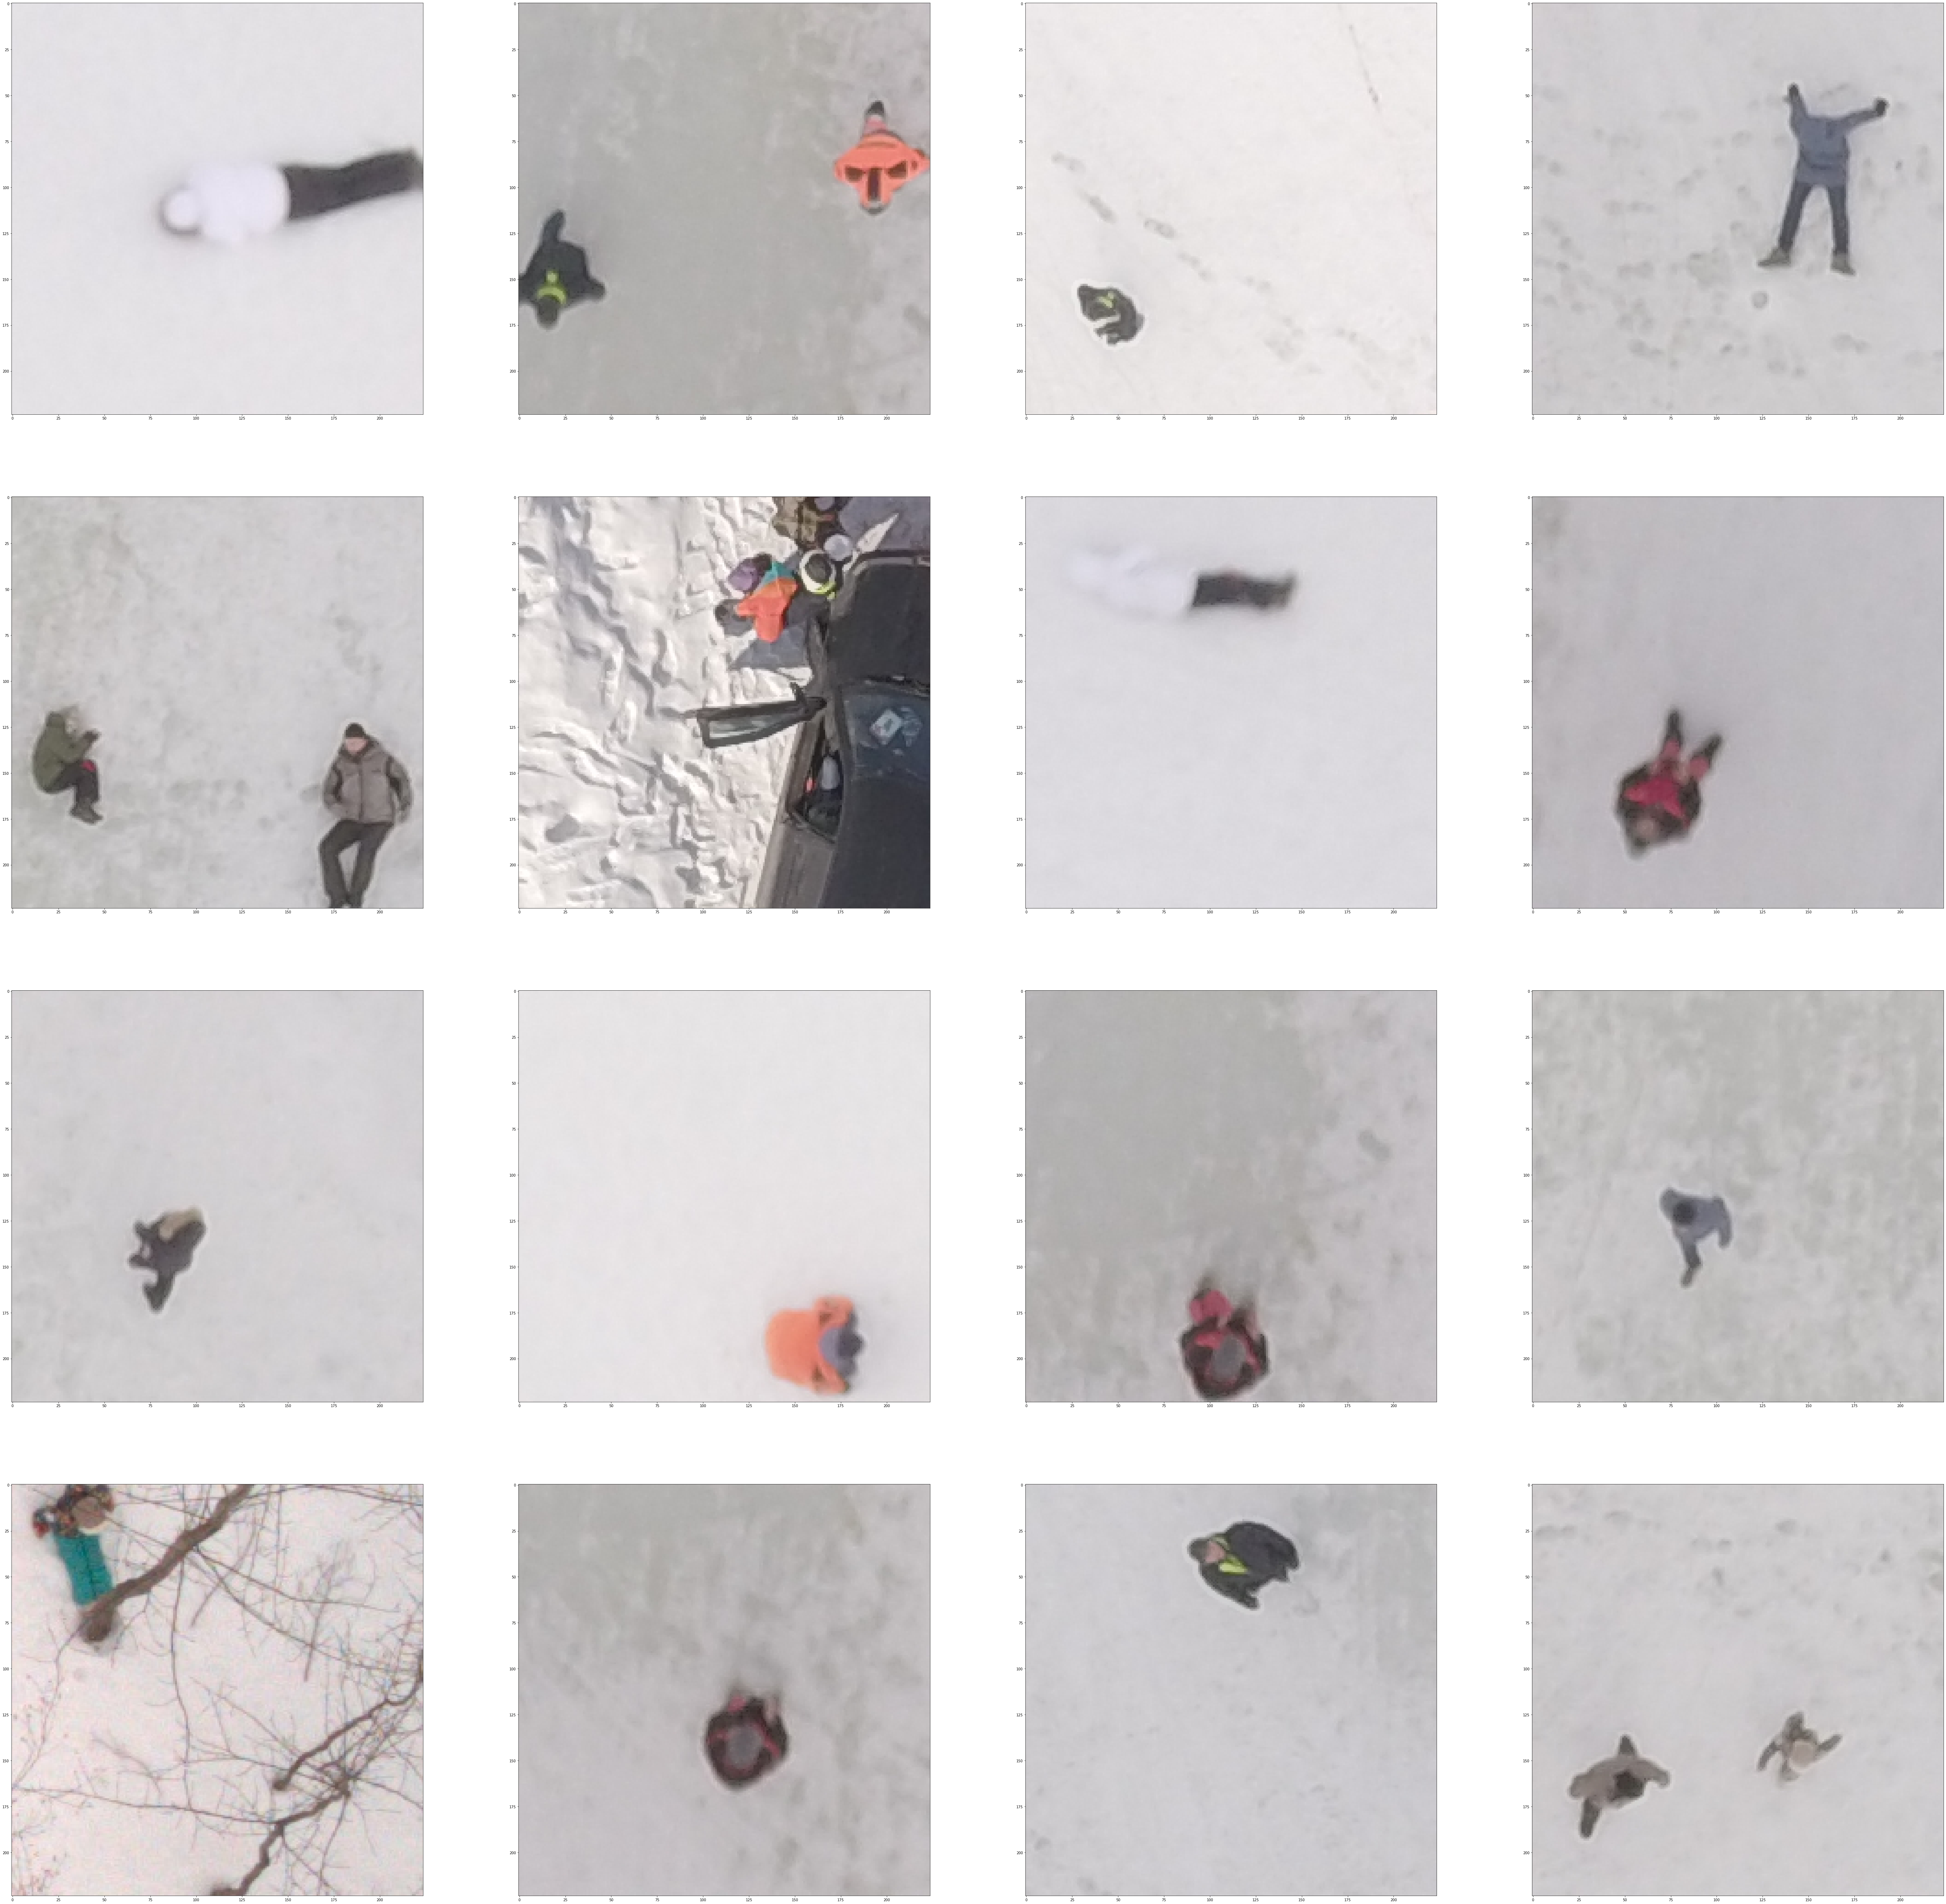

Pedestrian size: 70772


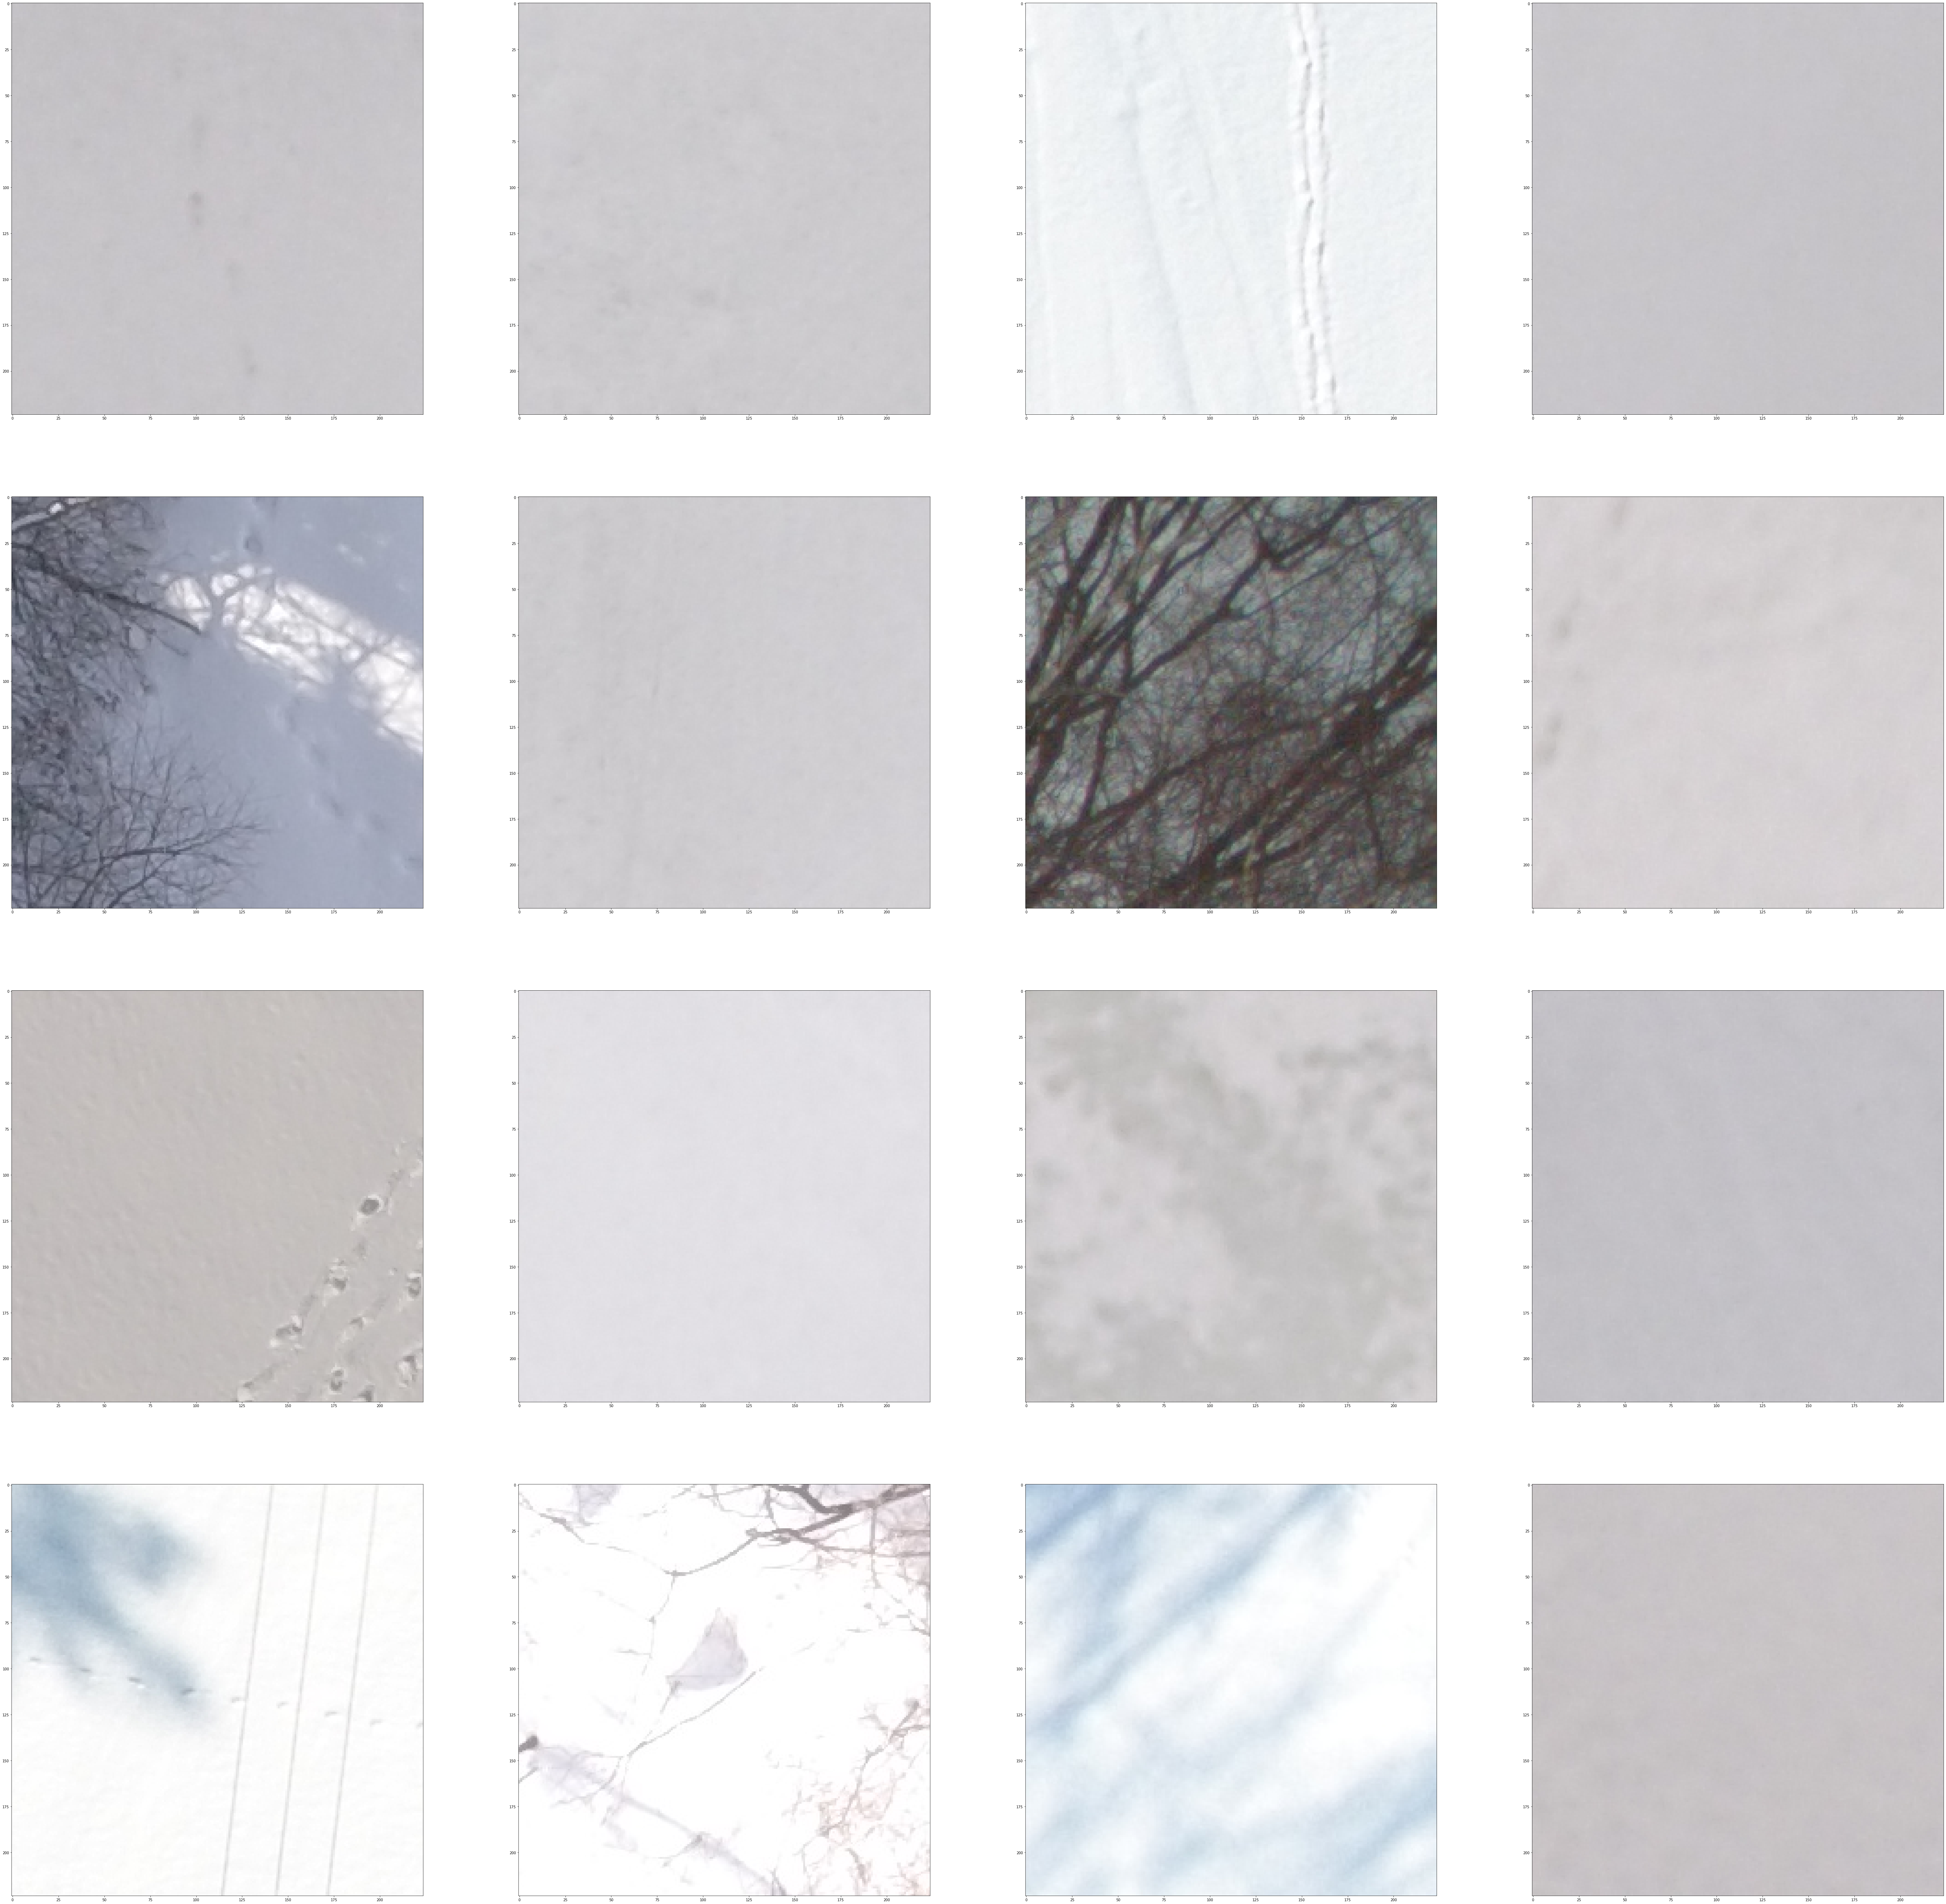

In [5]:
from pathlib import Path
import json
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

config = json.load(open('config.json', 'r'))
pedestrian_files = glob.glob(config['ladd_crop_base_path']+'/Pedestrian/*.png')
background_files = glob.glob(config['ladd_crop_base_path']+'/Background/*.png')
pedestrian_size = len(pedestrian_files)
background_size = len(background_files)
    
def plot_figures(figures, nrows = 4, ncols=4):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """
    fig=plt.figure(figsize=(100, 100))
    columns = ncols
    rows = nrows
    for i in range(1, len(figures)):
        img = figures[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

# show Pedestreans
files = list(np.random.choice(pedestrian_files, size=17))
imgs = []

for f in files:
    img_bgr = cv2.imread(f)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    imgs.append(img_rgb)
print(f'Pedestrian size: {pedestrian_size}')
plot_figures(imgs)

files = list(np.random.choice(background_files, size=17))
imgs = []

for f in files:
    img_bgr = cv2.imread(f)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    imgs.append(img_rgb)
print(f'Pedestrian size: {background_size}')
plot_figures(imgs)

In [2]:
from img2vec import img2vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2

img2vec = img2vec.Img2Vec()
image_pathes = pedestrian_files

image_vectors = {}
for image_path in image_pathes:
    vec = img2vec.get_vec(image_path)
    image_vectors[image_path] = vec
    
X = np.stack(list(image_vectors.values()))

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(X)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
print(np.shape(pca_result_50))

tsne = TSNE(n_components=2, verbose=1, n_iter=3000)
tsne_result = tsne.fit_transform(pca_result_50)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
plt.scatter(tsne_result_scaled[:,0], tsne_result_scaled[:,1])

images = []
for image_path in image_pathes:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (50,50))
    images.append(image)

fig, ax = plt.subplots(figsize=(20,15))
artists = []

for xy, i in zip(tsne_result_scaled, images):
    x0, y0 = xy
    img = OffsetImage(i, zoom=.7)
    ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
ax.update_datalim(tsne_result_scaled)
ax.autoscale(enable=True, axis='both', tight=True)
plt.show()

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv1_conv/Conv2D (defined at /home/gosha20777/files/projects/lacmus-research/crops_research_gosha20777/img2vec/img2vec.py:36) ]] [Op:__inference_distributed_function_7829]

Function call stack:
distributed_function


In [ ]:
from img2vec import img2vec

img2vec = img2vec.Img2Vec()
image_pathes = list(np.random.choice(background_files, size=10000))

image_vectors = {}
for image_path in image_pathes:
    vec = img2vec.get_vec(image_path)
    image_vectors[image_path] = vec
    
X = np.stack(list(image_vectors.values()))

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(X)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
print(np.shape(pca_result_50))

tsne = TSNE(n_components=2, verbose=1, n_iter=3000)
tsne_result = tsne.fit_transform(pca_result_50)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
plt.scatter(tsne_result_scaled[:,0], tsne_result_scaled[:,1])

images = []
for image_path in image_pathes:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (50,50))
    images.append(image)

fig, ax = plt.subplots(figsize=(20,15))
artists = []

for xy, i in zip(tsne_result_scaled, images):
    x0, y0 = xy
    img = OffsetImage(i, zoom=.7)
    ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
ax.update_datalim(tsne_result_scaled)
ax.autoscale(enable=True, axis='both', tight=True)
plt.show()

In [ ]:
from img2vec import img2vec

img2vec = img2vec.Img2Vec()
image_pathes = list(pedestrian_files + image_pathes)

image_vectors = {}
for image_path in image_pathes:
    vec = img2vec.get_vec(image_path)
    image_vectors[image_path] = vec
    
X = np.stack(list(image_vectors.values()))

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(X)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
print(np.shape(pca_result_50))

tsne = TSNE(n_components=2, verbose=1, n_iter=3000)
tsne_result = tsne.fit_transform(pca_result_50)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
plt.scatter(tsne_result_scaled[:,0], tsne_result_scaled[:,1])

images = []
for image_path in image_pathes:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (50,50))
    images.append(image)

fig, ax = plt.subplots(figsize=(20,15))
artists = []

for xy, i in zip(tsne_result_scaled, images):
    x0, y0 = xy
    img = OffsetImage(i, zoom=.7)
    ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
ax.update_datalim(tsne_result_scaled)
ax.autoscale(enable=True, axis='both', tight=True)
plt.show()